# 离散傅里叶变换模型

经过前面几篇博客的讲解，我们已经熟悉了傅里叶变换中的很多性质和概念，现在我们把它们整合在一起，来实现一个完整的离散傅里叶变换模型

完整的离散傅里叶变换模型包括
+ 离散傅里叶信号分析
+ 离散傅里叶信号合成

由于很多知识点都已经说过了，因此接下来以代码和注释为主，来说明完整的离散傅里叶变换模型

In [1]:
import numpy as np
import math
from scipy.fftpack import fft, ifft
from scipy.signal import get_window

tol = 1e-14

In [38]:
from scipy.io.wavfile import read

INT16_FAC = (2**15)-1
INT32_FAC = (2**31)-1
INT64_FAC = (2**63)-1
norm_fact = {'int16':INT16_FAC, 'int32':INT32_FAC, 'int64':INT64_FAC,'float32':1.0,'float64':1.0}

def is_power2(num):
    return ((num & (num - 1)) == 0) and num != 0

def wavread(filename):
    fs, x = read(filename)
    
    x = np.float32(x)/norm_fact[x.dtype.name]
    return fs, x

def zero_phase_windowing(x, N):
    '''
    x(numpy array): 输入信号
    N(int): 补零后的大小
    '''
    
    M = len(x)
    
    if(M >= N):                      # 如果x的长度大于N，不需要补零，直接返回
        return x
    
    buffer = np.zeros(N)
    hM1 = (M+1)//2
    hM2 = M//2
    
    buffer[:hM1] = x[-hM1:]
    buffer[-hM2:] = x[:hM2]
    
    return buffer

def undo_zero_phase_windowing(buffer, M):
    
    hM1 = (M+1)//2
    hM2 = M//2
    
    y = np.zeros(M)
    y[:hM2] = buffer[-hM2:]                                        # 零相位窗口逆操作
    y[-hM1:] = buffer[:hM1]
    
    return y

In [39]:
def dftAnal(x, w, N):
    '''
    x(numpy array): 输入信号
    w(numpy array): 窗函数生成的信号
    N(int): FFT大小
    '''
    
    if not(is_power2(N)):
        raise ValueError('FFT size(N) is not a power of 2')            # FFT大小必须为2的次幂
        
    if(w.size > N):
        raise ValueError('Window size(M) is bigger than FFT size')     # 窗大小必须小于等于FFT大小
        
        
    # 加窗 
    w = w/sum(w)                                                       # 对窗函数进行归一化
    xw = x*w                                                           # 加窗
    
    # zero-phase windowing
    fftbuffer = zero_phase_windowing(xw, N)                             # 零相位窗 + 补零
    
    X = fft(fftbuffer)                                                 # FFT
    hN = (N//2)+1                                                      # 一半大小（包含0），因为FFT是对称的，因此我们只需要一半数据即可
    absX = np.abs(X[:hN])
    absX[ absX<np.finfo(float).eps ] = np.finfo(float).eps             # 加上eps，防止在log时出错
    mX = 20*np.log10(absX)                                             # 计算分贝幅度
    X[:hN].real[np.abs(X[:hN].real) < tol] = 0.0
    X[:hN].imag[np.abs(X[:hN].imag) < tol] = 0.0
    pX = np.unwrap(np.angle(X[:hN]))
    
    return mX, pX

def dftSynth(mX, pX, M):
    '''
    用DFT合成信号
    mX(numpy array):分贝幅度
    pX(numpy array):相位
    M(int):窗函数大小
    '''
    
    hN = mX.size                                                      # 频谱的一半大小（包括位置0）
    N = (hN-1)*2                                                      # FFT 大小
    if not(is_power2(N)):
        raise ValueError('size of mX is not (N/2)+1')                 # FFT大小必须为2的次幂
        
    Y = np.zeros(N, dtype=complex)
    
    Y[:hN] = 10**(mX/20) * np.exp(1j*pX)                              # 从mX和pX中得到一个复数即DFT的结果，正半边
    Y[hN:] = 10**(mX[-2:0:-1]/20) * np.exp(1j*pX[-2:0:-1])            # 从mX和pX中得到一个复数即DFT的结果，负半边
                                                                      # （由对称性可知，负半边不包括倒数第一个点）
    fftbuffer = np.real(ifft(Y))                                      # IFFT
    
    y = undo_zero_phase_windowing(fftbuffer, M)                       # 零相位窗口逆操作
    
    return y

def dftModel(x, w, N):
    mX, pX = dftAnal(x, w, N)
    y = dftSynth(mX, pX, w.size)
    return y

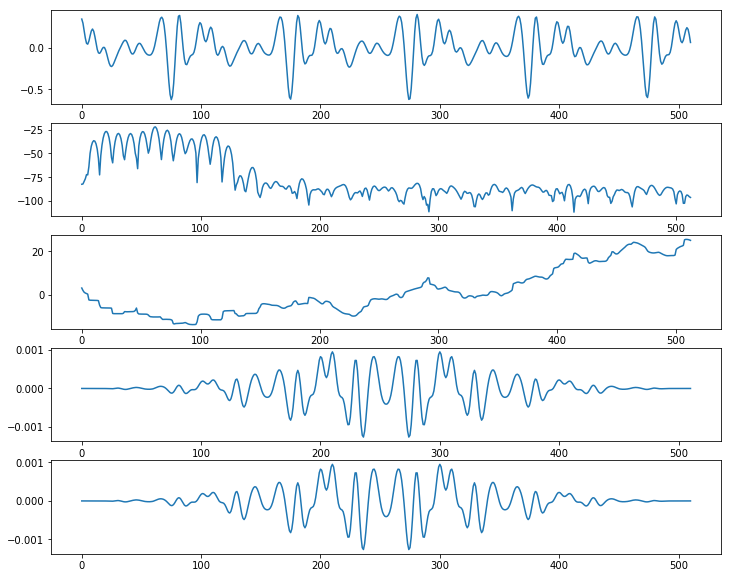

In [40]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
%matplotlib inline


audio_path = 'sounds/oboe-A4.wav'
fs, input_x = wavread(audio_path)

start_in_second = 0.2
start_index = int(fs*start_in_second)
M = 511
N = 1024
x = input_x[start_index:start_index + M]
w = get_window('blackman', M)

mX, pX = dftAnay(x, w, N)
y = dftSynth(mX, pX, M)

yy = dftModel(x, w, N)

plt.figure(figsize=(12,10))
plt.subplot(511)
plt.plot(x)

plt.subplot(512)
plt.plot(mX)

plt.subplot(513)
plt.plot(pX)

plt.subplot(514)
plt.plot(y)

plt.subplot(515)
plt.plot(yy)